# Yearly Comparison of Dispatched Load for NSW; An Automated NEM Data Analysis

In this notebook we will automate zipped data retrieving from NEMWEB and gain some insight on dispatch changes across 2010, 2016 and 2022 for all 12 months in NSW

In [67]:
import pandas as pd
import urllib.request
import zipfile
import matplotlib.pyplot as plt
import seaborn as sb

In [68]:
# Assign the year (Other years will be based of this year)
year = '2022'
# steps to previous years
year_step = 6
# Identify the table to download
data = 'DISPATCHLOAD'
state = 'NSW1'
Month = [format(i, '02d') for i in range(1, 13)]
col_load = ['SETTLEMENTDATE','DUID','INTERVENTION','TOTALCLEARED']

In [69]:
# Function to download and extract data from website for a chosen year over its 12 months and appends them
def data_extract (year,data,state,Month,col_load):
    
    # To identify the generators source of fuel we need this table to be merged based on DUID 
    DUID_Info = pd.read_excel("NEM Registration and Exemption List (1).xlsx",sheet_name = "Generators and Scheduled Loads")
    DUID_df = DUID_Info[(DUID_Info.notna().all(axis=1)) & (DUID_Info['Technology Type - Primary'] != '-')]
    DUID_df = DUID_df[['DUID','Technology Type - Primary','Fuel Source - Primary']]
    
    
    
    cleared = pd.DataFrame()
    
    for month in Month:
        print(month)
        url = f'https://nemweb.com.au/Data_Archive/Wholesale_Electricity/MMSDM/{year}/MMSDM_{year}_{month}/MMSDM_Historical_Data_SQLLoader/DATA/PUBLIC_DVD_{data}_{year}{month}010000.zip'
        file_name = f'{year}{month}010000.zip'
        urllib.request.urlretrieve(url, file_name)
    
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall()
        df = pd.read_csv(f'PUBLIC_DVD_{data}_{year}{month}010000.csv', engine='python',skiprows=1, skipfooter=1)
        
       
        df = df[col_load]
        df['month'] = month
        # Checking for no intervantions
        df = df[df['INTERVENTION']== 0]
         
        cleared = cleared.append(pd.merge(df, DUID_df, on = "DUID", how = "inner"))
        
    return cleared

In [70]:
# call the function for given 3 years and calculate the total % of load dispatch
yearly_cleared = pd.DataFrame()
for i in range(3):
    year = int(year)
    print(year)
    cleared = data_extract (year,data,state,Month,col_load)
    cleared_copy = cleared.copy()
    cleared['SETTLEMENTDATE'] = pd.to_datetime(cleared['SETTLEMENTDATE'])
    month_cleared = cleared.groupby(['month','Technology Type - Primary','Fuel Source - Primary']).sum()
    month_cleared.reset_index(inplace = True)
    month_cleared['perc_cleared'] = (month_cleared['TOTALCLEARED']/month_cleared.TOTALCLEARED.sum())*100
    month_cleared['year'] = year
    yearly_cleared = yearly_cleared.append(month_cleared)
    year = int(year) - year_step

2022
01
02
03
04
05
06
07
08
09
10
11
12
2016
01
02
03
04
05
06
07
08
09
10
11
12
2010
01
02
03
04
05
06
07
08
09
10
11
12


In [71]:
# yearly_cleared shows the total cleared load dispatch based on month and fuel source
print(yearly_cleared)

,month,Technology Type - Primary,Fuel Source - Primary,INTERVENTION,TOTALCLEARED,perc_cleared,year
0,01,Combustion,Fossil,0,1.496953e+08,5.869431,2022
1,01,Renewable,Hydro,0,2.119032e+07,0.830855,2022
2,01,Renewable,Solar,0,1.337169e+07,0.524293,2022
3,01,Renewable,Wind,0,3.078004e+07,1.206860,2022
4,01,Storage,,0,6.441937e+04,0.002526,2022
...,...,...,...,...,...,...,...
31,11,Renewable,Hydro,0,3.162093e+07,1.359534,2010
32,11,Renewable,Wind,0,1.893064e+06,0.081392,2010
33,12,Combustion,Fossil,0,1.603044e+08,6.892243,2010
34,12,Renewable,Hydro,0,3.004400e+07,1.291734,2010


In [73]:
# yearly_source shows the total cleared load dispatch based on year and fuel source
yearly_source = yearly_cleared.groupby(['year','Technology Type - Primary','Fuel Source - Primary']).sum()
yearly_source.reset_index(inplace = True)
yearly_source

,year,Technology Type - Primary,Fuel Source - Primary,INTERVENTION,TOTALCLEARED,perc_cleared
0,2010,Combustion,Fossil,0,2.008270e+09,86.345037
1,2010,Renewable,Hydro,0,2.978626e+08,12.806523
2,2010,Renewable,Wind,0,1.973357e+07,0.848440
3,2016,Combustion,Fossil,0,1.946168e+09,80.917989
4,2016,Renewable,Hydro,0,3.356525e+08,13.955797
5,2016,Renewable,Solar,0,5.564863e+06,0.231377
6,2016,Renewable,Wind,0,1.177263e+08,4.894837
7,2022,Combustion,Fossil,0,1.703813e+09,66.805084
8,2022,Renewable,Hydro,0,3.079958e+08,12.076260
9,2022,Renewable,Solar,0,1.358496e+08,5.326548


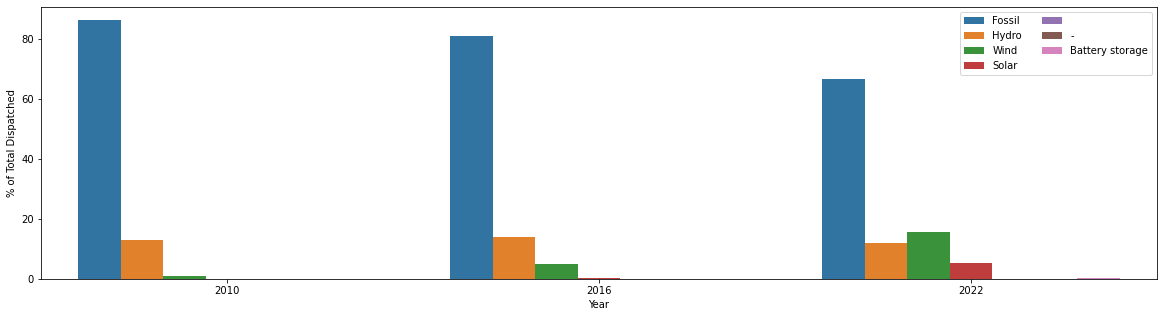

In [75]:
# What is the contribution of each dispatched generator source per year?
fig, ax = plt.subplots(figsize=(20, 5))
sb.barplot(data = yearly_source, x= "year", y= "perc_cleared", hue = "Fuel Source - Primary")#,palette ="Spectrum")
ax.set_ylabel('% of Total Dispatched')
ax.set_xlabel('Year')
#ax.set_xticklabels(categories_list)
plt.legend(loc="upper right", ncol= 2)

plt.show()